In [1]:
import pyvista
from dolfinx import mesh, fem, plot, io, default_scalar_type
from dolfinx.fem.petsc import LinearProblem
from mpi4py import MPI
import ufl
import basix
import numpy as np
import gmsh

In [2]:
#from fenics import *

In [3]:
L = 1
W = 0.2
mu = 1
rho = 1
delta = W / L
gamma = 0.4 * delta**2
beta = 1.25
lambda_ = beta
g = gamma

In [4]:
#domain = mesh.create_box(MPI.COMM_WORLD, [np.array([0, 0, 0]), np.array([L, W, W])],
#                         [30, 9, 9], cell_type=mesh.CellType.hexahedron)
#V = fem.VectorFunctionSpace(domain, ("Lagrange", 1))

In [5]:
from dolfinx.io import gmshio
gmsh.initialize()
box=gmsh.model.occ.addBox(0,0,0,L,W,W)
gmsh.model.occ.synchronize()
gdim = 3
gmsh.model.addPhysicalGroup(gdim, [box], 1)
gmsh.option.setNumber("Mesh.CharacteristicLengthMin", 0.03)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax", 0.03)
#gmsh.option.setNumber("Mesh.SubdivisionAlgorithm", 1)
gmsh.model.mesh.generate(gdim)
gmsh_model_rank = 0
mesh_comm = MPI.COMM_WORLD
domain, cell_markers, facet_markers = gmshio.model_to_mesh(gmsh.model, mesh_comm, gmsh_model_rank, gdim=gdim)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 30%] Meshing curve 4 (Line)
Info    : [ 40%] Meshing curve 5 (Line)
Info    : [ 50%] Meshing curve 6 (Line)
Info    : [ 50%] Meshing curve 7 (Line)
Info    : [ 60%] Meshing curve 8 (Line)
Info    : [ 70%] Meshing curve 9 (Line)
Info    : [ 80%] Meshing curve 10 (Line)
Info    : [ 90%] Meshing curve 11 (Line)
Info    : [100%] Meshing curve 12 (Line)
Info    : Done meshing 1D (Wall 0.000537238s, CPU 0.00093s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 20%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : [ 40%] Meshing surface 3 (Plane, Frontal-Delaunay)
Info    : [ 50%] Meshing surface 4 (Plane, Frontal-Delaunay)
Info    : [ 70%] Meshing surface 5 (Plane, Frontal-Delaunay)
Info    : [ 90%] Meshing surface 6 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0244229s,

In [6]:
V = fem.functionspace(domain, ('Lagrange', 1, (domain.geometry.dim,)))

In [7]:
fem.FunctionSpace??

Init signature:
fem.FunctionSpace(
    mesh: 'Mesh',
    element: 'ufl.FiniteElementBase',
    cppV: 'typing.Union[_cpp.fem.FunctionSpace_float32, _cpp.fem.FunctionSpace_float64]',
)
Source:        
class FunctionSpace(ufl.FunctionSpace):
    """A space on which Functions (fields) can be defined."""

    _cpp_object: typing.Union[_cpp.fem.FunctionSpace_float32, _cpp.fem.FunctionSpace_float64]
    _mesh: Mesh

    def __init__(
        self,
        mesh: Mesh,
        element: ufl.FiniteElementBase,
        cppV: typing.Union[_cpp.fem.FunctionSpace_float32, _cpp.fem.FunctionSpace_float64],
    ):
        """Create a finite element function space.

        Note:
            This initialiser is for internal use and not normally called
            in user code. Use :func:`functionspace` to create a function space.

        Args:
            mesh: Mesh that space is defined on
            element: UFL finite element
            cppV: Compiled C++ function space.

        """
        if mes

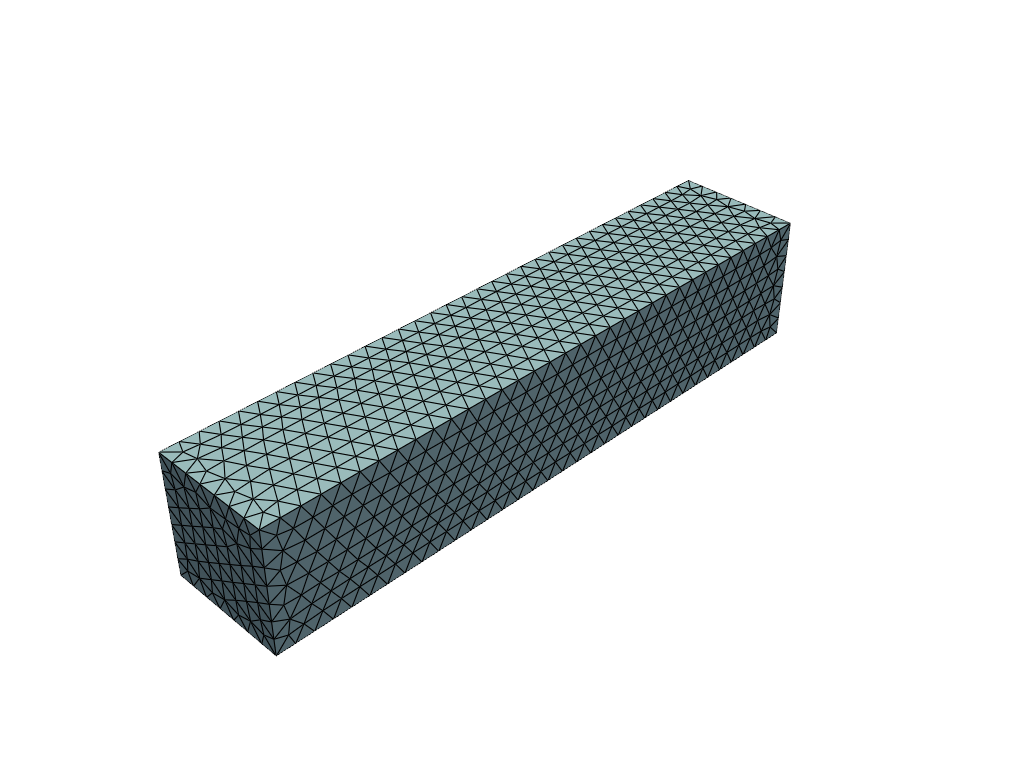

In [8]:
p = pyvista.Plotter()
topology, cell_types, geometry = plot.vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

p.add_mesh(grid, show_edges=True)
p.show()

In [10]:
V

FunctionSpace(Mesh(blocked element (Basix element (P, tetrahedron, 1, equispaced, unset, False, float64, []), (3,)), 0), blocked element (Basix element (P, tetrahedron, 1, gll_warped, unset, False, float64, []), (3,)))

In [11]:
#def clamped_boundary(x):
#    return np.isclose(x[0], 0)
#
#
#fdim = domain.topology.dim - 1
#boundary_facets = mesh.locate_entities_boundary(domain, fdim, clamped_boundary)
#
#u_D = np.array([0, 0, 0], dtype=default_scalar_type)
#bc = fem.dirichletbc(u_D, fem.locate_dofs_topological(V, fdim, boundary_facets), V)

In [12]:
def clamped_boundary(x):
    return np.isclose(x[0], 0)

def clamped_boundary1(x):
    return np.isclose(x[0], 1)

boundary_dofs = fem.locate_dofs_geometrical(V, clamped_boundary)
boundary_dofs1 = fem.locate_dofs_geometrical(V, clamped_boundary1)
u_D = np.array([0, 0, 0], dtype=default_scalar_type)
#bc = fem.dirichletbc(u_D, boundary_dofs, V)
bc_0 = fem.dirichletbc(u_D, boundary_dofs, V)
bc_1 = fem.dirichletbc(u_D, boundary_dofs1, V)
#bc = [bc_0, bc_1]
bc = [bc_0]

In [13]:
domain.geometry.x

array([[0.02166747, 0.17854794, 0.        ],
       [0.        , 0.2       , 0.        ],
       [0.        , 0.17142857, 0.        ],
       ...,
       [0.97899825, 0.02076676, 0.2       ],
       [1.        , 0.02857143, 0.2       ],
       [1.        , 0.        , 0.2       ]])

In [14]:
len(domain.geometry.x)

1875

In [15]:
ds = ufl.Measure("ds", domain=domain)

In [16]:
def epsilon(u):
    return ufl.sym(ufl.grad(u))  # Equivalent to 0.5*(ufl.nabla_grad(u) + ufl.nabla_grad(u).T)


def sigma(u):
    return lambda_ * ufl.nabla_div(u) * ufl.Identity(len(u)) + 2 * mu * epsilon(u)

T = fem.Constant(domain, default_scalar_type((0, 0, 0)))
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
f = fem.Constant(domain, default_scalar_type((0, 0, -rho * g)))
a = ufl.inner(sigma(u), epsilon(v)) * ufl.dx
L = ufl.dot(f, v) * ufl.dx + ufl.dot(T, v) * ds

In [17]:
problem = LinearProblem(a, L, bcs=bc, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

In [18]:
uh.x.array

array([-1.75752411e-03,  5.29270075e-04, -1.03437145e-03, ...,
        2.89496660e-02,  2.19170604e-04, -2.24796679e-01])

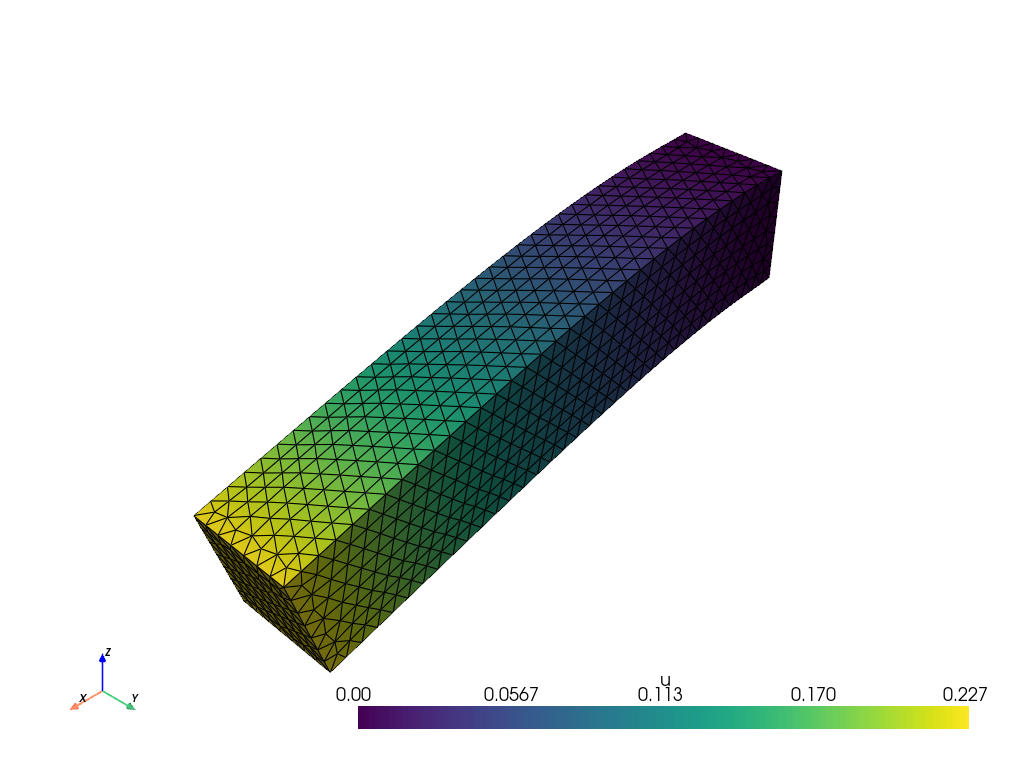

In [19]:
#pyvista.start_xvfb()

# Create plotter and pyvista grid
p = pyvista.Plotter()
topology, cell_types, geometry = plot.vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

# Attach vector values to grid and warp grid by vector
grid["u"] = uh.x.array.reshape((geometry.shape[0], 3))
#actor_0 = p.add_mesh(grid, style="wireframe", color="k")
warped = grid.warp_by_vector("u", factor=1.0)
actor_1 = p.add_mesh(warped, show_edges=True)
p.show_axes()
if not pyvista.OFF_SCREEN:
    p.show()
else:
    figure_as_array = p.screenshot("deflection.png")

In [25]:
s = sigma(uh) - 1. / 3 * ufl.tr(sigma(uh)) * ufl.Identity(len(uh))
von_Mises = ufl.sqrt(3. / 2 * ufl.inner(s, s))
V_von_mises = fem.functionspace(domain, ("DG", 0))
stress_expr = fem.Expression(von_Mises, V_von_mises.element.interpolation_points())
stresses = fem.Function(V_von_mises)
stresses.interpolate(stress_expr)

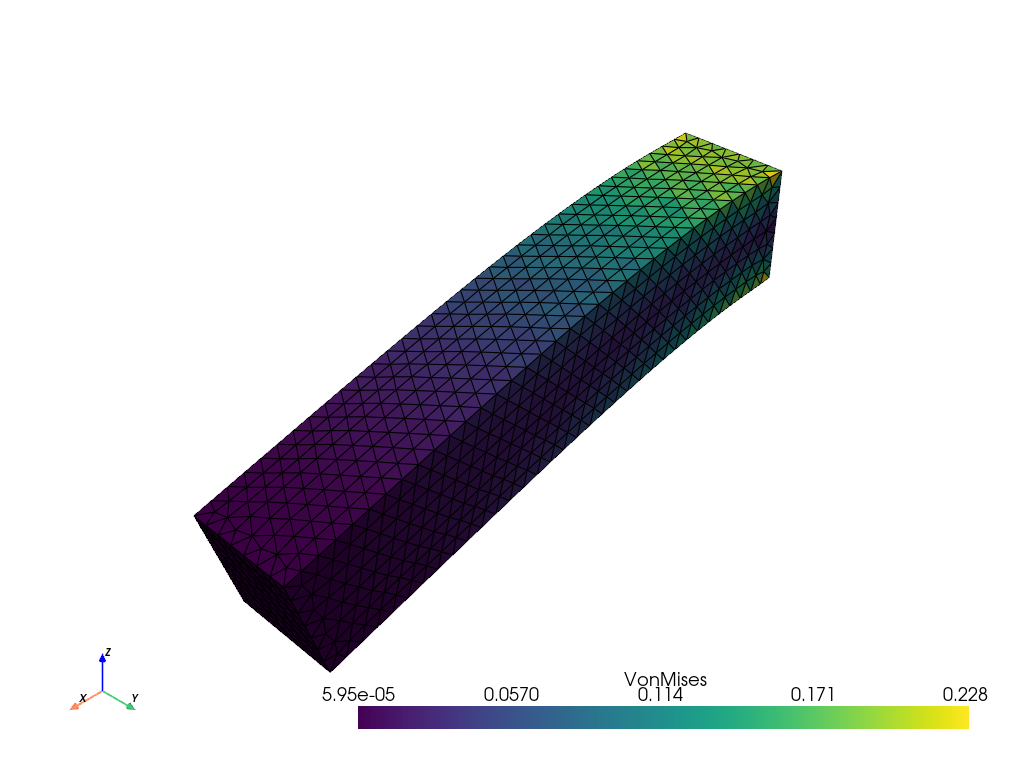

In [26]:
warped.cell_data["VonMises"] = stresses.vector.array
warped.set_active_scalars("VonMises")
p = pyvista.Plotter()
p.add_mesh(warped, show_edges=True)
p.show_axes()
if not pyvista.OFF_SCREEN:
    p.show()
else:
    stress_figure = p.screenshot(f"stresses.png")

In [27]:
uh.vector.array

array([-1.75752411e-03,  5.29270075e-04, -1.03437145e-03, ...,
        2.89496660e-02,  2.19170604e-04, -2.24796679e-01])

In [28]:
len(uh.vector.array)

5625

In [29]:
V_von_mises.mesh.geometry.x

array([[0.02166747, 0.17854794, 0.        ],
       [0.        , 0.2       , 0.        ],
       [0.        , 0.17142857, 0.        ],
       ...,
       [0.97899825, 0.02076676, 0.2       ],
       [1.        , 0.02857143, 0.2       ],
       [1.        , 0.        , 0.2       ]])

In [30]:
len(V_von_mises.mesh.geometry.x)

1875

In [31]:
stresses.vector.array

array([1.86934443e-01, 1.31875004e-01, 1.82013858e-01, ...,
       1.17615465e-04, 2.49903967e-04, 1.49147433e-04])

In [32]:
len(stresses.vector.array)

7503

In [33]:
uh.x.array

array([-1.75752411e-03,  5.29270075e-04, -1.03437145e-03, ...,
        2.89496660e-02,  2.19170604e-04, -2.24796679e-01])

In [34]:
len(uh.x.array)

5625